# Hall of Fame Baseball
## Binary Classification
Binary Classification of baseball data from 1871-2021, in order to indentify what statistics make up hall of fame baseball players.   
How can this knowledge be used for current players, managers, teams?

In [2]:
#Import statments
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
from sklearn.utils import resample

import dtale

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('default')  # 'dark_background'

C:\Users\bmcca\Anaconda3\envs\data\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
#loading in data
batting = pd.read_csv("Batting.csv")
fielding = pd.read_csv("Fielding.csv")
pitching = pd.read_csv("Pitching.csv")
allstar = pd.read_csv("AllstarFull.csv")
awards = pd.read_csv("AwardsPlayers.csv")
hof = pd.read_csv("HallOfFame.csv")
info = pd.read_csv("People.csv")
#post = pd.read_csv("SeriesPost.csv")

In [4]:
#I provided the readme file from the data to help with understanding of all the acronyms
#Cleaning all data into usable format for analysis
#Merging all data sets into one 23005X50
aggregation_functions_f = {'POS': 'first', 'G': 'sum','GS': 'sum', 'InnOuts':'sum',
                           'PO':'sum','A':'sum','E':'sum','DP':'sum'}
aggregation_functions_b = {'G': 'sum','AB': 'sum', 'R':'sum','H':'sum',
                           '2B':'sum','3B':'sum','HR':'sum','RBI':'sum','SB':'sum',
                           'CS':'sum','BB':'sum','SO':'sum','IBB':'sum','HBP':'sum',
                           'SH':'sum','SF':'sum','GIDP':'sum'}
aggregation_functions_p = {'W': 'sum','L': 'sum', 'G':'sum','GS':'sum',
                           'CG':'sum','SHO':'sum','SV':'sum','IPouts':'sum','H':'sum',
                           'ER':'sum','HR':'sum','BB':'sum','SO':'sum','BAOpp':'sum',
                           'R':'sum','GIDP':'sum','WP':'sum','BK':'sum'}
combined_f = fielding.groupby(fielding['playerID']).aggregate(aggregation_functions_f)
combined_b = batting.groupby(batting['playerID']).aggregate(aggregation_functions_b)
combined_p = pitching.groupby(pitching['playerID']).aggregate(aggregation_functions_p)
merged_df = pd.merge(combined_f,combined_b, on='playerID',how = 'outer')
merged_df = pd.merge(merged_df,combined_p, on='playerID',how='outer')
merged_df['POS'].fillna("DH",inplace=True)
info = info[['playerID','nameFirst','nameLast','weight','height']]
hof['inducted'] = hof['inducted'].map({'Y': 1, 'N': 0})
hof = hof[hof['category']=='Player']
hof = hof[['playerID','inducted']]
awards_clean = pd.DataFrame(awards.groupby(['playerID'])['playerID'].count())
awards_clean.rename(columns={"playerID": "Awards"},inplace=True)
as_clean = pd.DataFrame(allstar.groupby(['playerID'])['playerID'].count())
as_clean.rename(columns={"playerID": "AS_ap"},inplace=True)
merged_df = pd.merge(merged_df,info, on='playerID',how = 'outer')
merged_df = pd.merge(merged_df,hof, on='playerID',how='outer')
merged_df = pd.merge(merged_df,awards_clean, on='playerID',how='outer')
merged_df = pd.merge(merged_df,as_clean, on='playerID',how='outer')
merged_df = merged_df.fillna(0)
merged_df = merged_df[merged_df['POS']!=0]
merged_df = merged_df.set_index('playerID')
merged_df

,POS,G_x,GS_x,InnOuts,PO,A,E,DP,G_y,AB,...,GIDP_y,WP,BK,nameFirst,nameLast,weight,height,inducted,Awards,AS_ap
playerID,,,,,,,,,,,,,,,,,,,,,
aardsda01,P,331.0,0.0,1011.0,11.0,29.0,3.0,2.0,331.0,4.0,...,21.0,12.0,1.0,David,Aardsma,215.0,75.0,0.0,0.0,0.0
aaronha01,OF,3020.0,2977.0,78414.0,7436.0,429.0,144.0,218.0,3298.0,12364.0,...,0.0,0.0,0.0,Hank,Aaron,180.0,72.0,1.0,16.0,24.0
aaronto01,1B,387.0,206.0,6472.0,1317.0,113.0,22.0,124.0,437.0,944.0,...,0.0,0.0,0.0,Tommie,Aaron,190.0,75.0,0.0,0.0,0.0
aasedo01,P,448.0,91.0,3328.0,67.0,135.0,13.0,10.0,448.0,5.0,...,106.0,22.0,3.0,Don,Aase,190.0,75.0,0.0,0.0,1.0
abadan01,1B,9.0,4.0,138.0,37.0,1.0,1.0,3.0,15.0,21.0,...,0.0,0.0,0.0,Andy,Abad,184.0,73.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wilsoco01,DH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,Cody,Wilson,200.0,74.0,0.0,0.0,0.0
wilsoic01,DH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,Icehouse,Wilson,186.0,72.0,0.0,0.0,0.0
wrighro02,DH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,...,0.0,0.0,0.0,Ron,Wright,230.0,73.0,0.0,0.0,0.0


In [8]:
# Description of data
merged_df.describe()[['Awards', 'inducted','AS_ap']]

,Awards,inducted,AS_ap
count,23005.000000,23005.000000,23005.000000
mean,1.083112,0.009998,0.709194
std,3.453841,0.099490,2.132709
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,47.000000,1.000000,26.000000


In [174]:
#Easier way to look at data as well as do exploratory analysis 
d = dtale.show(merged_df)
d

Executing shutdown due to inactivity...
Executing shutdown due to inactivity...


2022-11-16 19:03:38,468 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...
Executing shutdown...


2022-11-16 19:03:50,675 - INFO     - Executing shutdown...


## Exploratory analysis

<AxesSubplot:xlabel='POS', ylabel='count'>

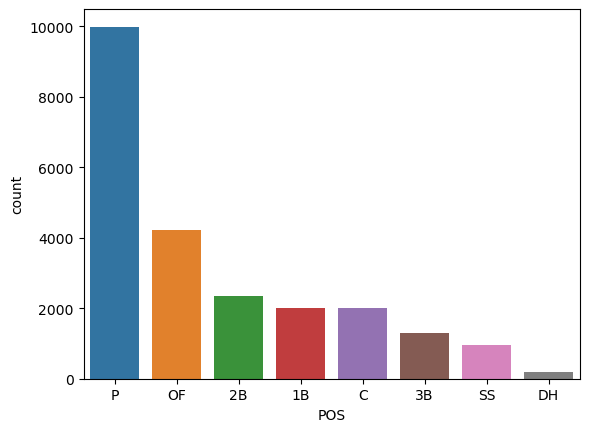

In [125]:
#Distribution of player positions 
sns.countplot(x="POS",data=merged_df,order=merged_df['POS'].value_counts().index)

<AxesSubplot:ylabel='inducted'>

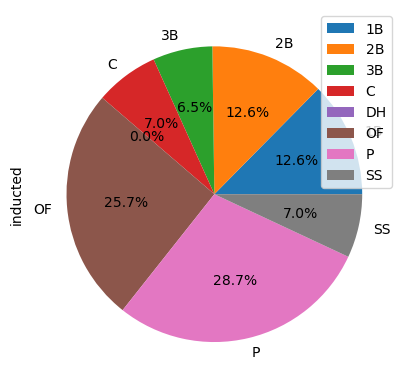

In [126]:
#Of the people in the Hall of Fame this is the distribution of players positions
#Inducted means is in the baseball Hall Of Fame
merged_df.groupby(['POS']).sum().plot(kind='pie',y='inducted',autopct='%.01f%%')

<AxesSubplot:ylabel='AS_ap'>

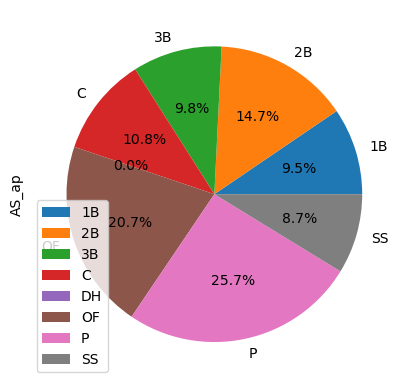

In [127]:
#Of the people that made allstar aperances this is the distribution of players positions
merged_df.groupby(['POS']).sum().plot(kind='pie',y='AS_ap',autopct='%.01f%%')

<AxesSubplot:ylabel='Awards'>

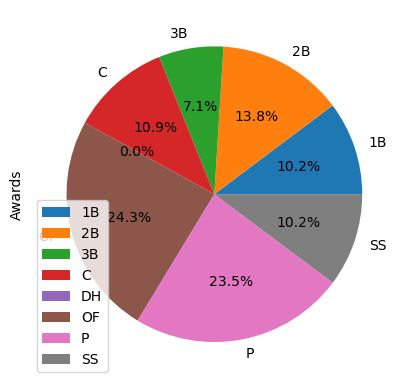

In [128]:
#Of the players the have won awards this is the distribution of players positions
merged_df.groupby(['POS']).sum().plot(kind='pie',y='Awards',autopct='%.01f%%')

<AxesSubplot:ylabel='AS_ap'>

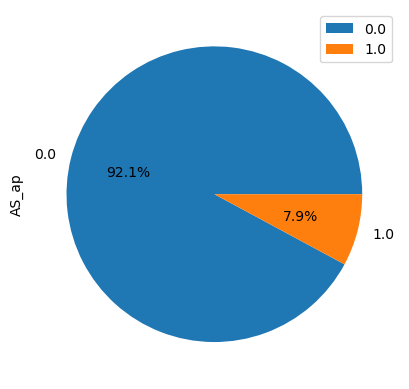

In [129]:
#Distibution of people that are in the HOF v the number of all star aperances
merged_df.groupby(['inducted']).sum().plot(kind='pie',y='AS_ap',autopct='%.01f%%')

<AxesSubplot:ylabel='Awards'>

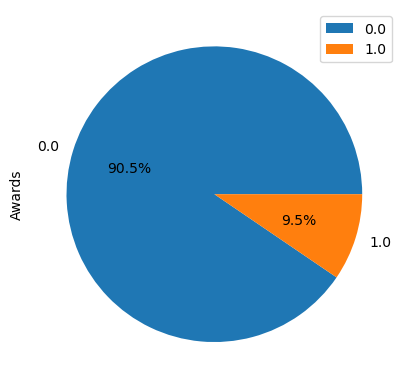

In [130]:
#Awards v HOF 
merged_df.groupby(['inducted']).sum().plot(kind='pie',y='Awards',autopct='%.01f%%')

<AxesSubplot:xlabel='inducted', ylabel='count'>

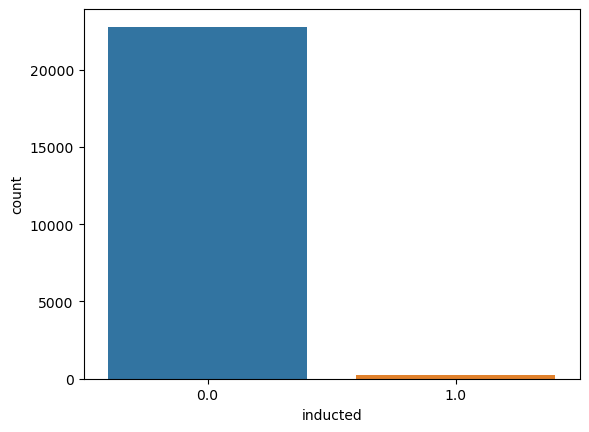

In [131]:
#data is very impalced will look into methods to compensate
#This is very concerning and will have to be delt with
#Distribution of HOF v not
sns.countplot(x='inducted',data=merged_df)

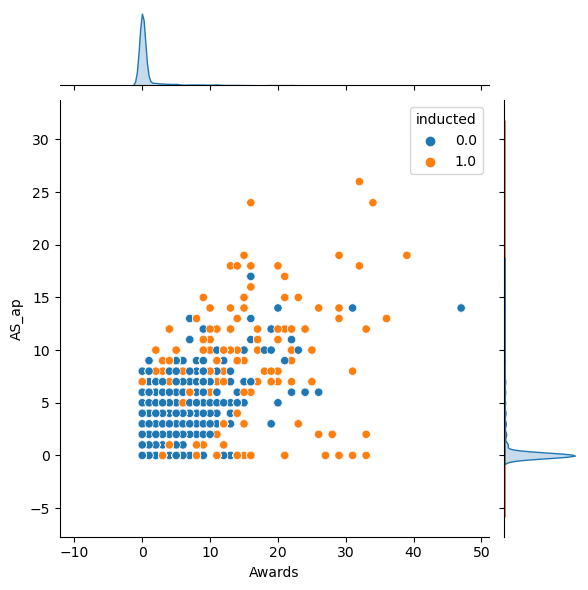

In [132]:
#Awards v All Star Apperances with HOF hue
#One outlier with about 47 awards and 15 all star aperances and not in the HOF
sns.jointplot(x='Awards',data=merged_df, y='AS_ap', hue='inducted')

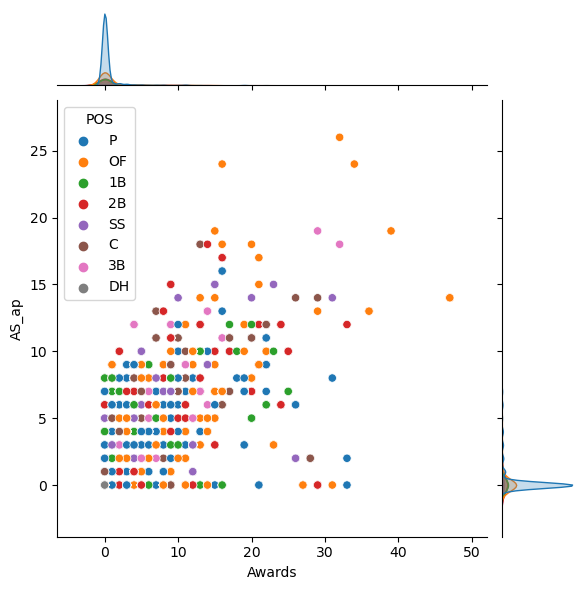

In [133]:
#Awards vs All Star Apperances Hue of divverent positions
#Outlier with both high awards and all star apperances were outfeilders
sns.jointplot(x='Awards',data=merged_df, y='AS_ap', hue='POS')

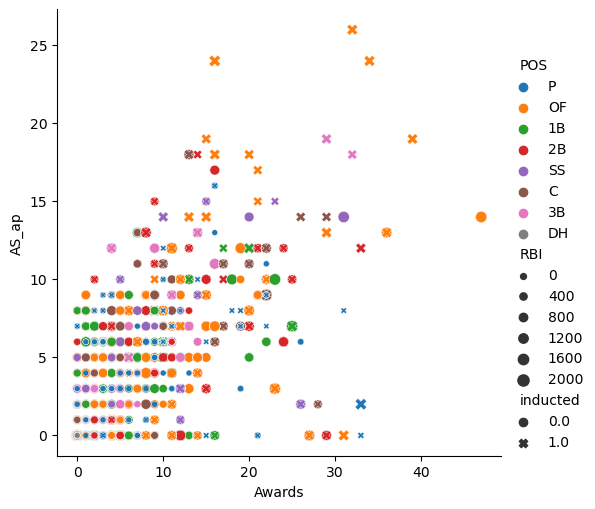

In [134]:
# People with lots of awards and all star apperances hove a high amount of RBIS
sns.relplot(data=merged_df,x='Awards',y='AS_ap',hue='POS',size='RBI',style='inducted')

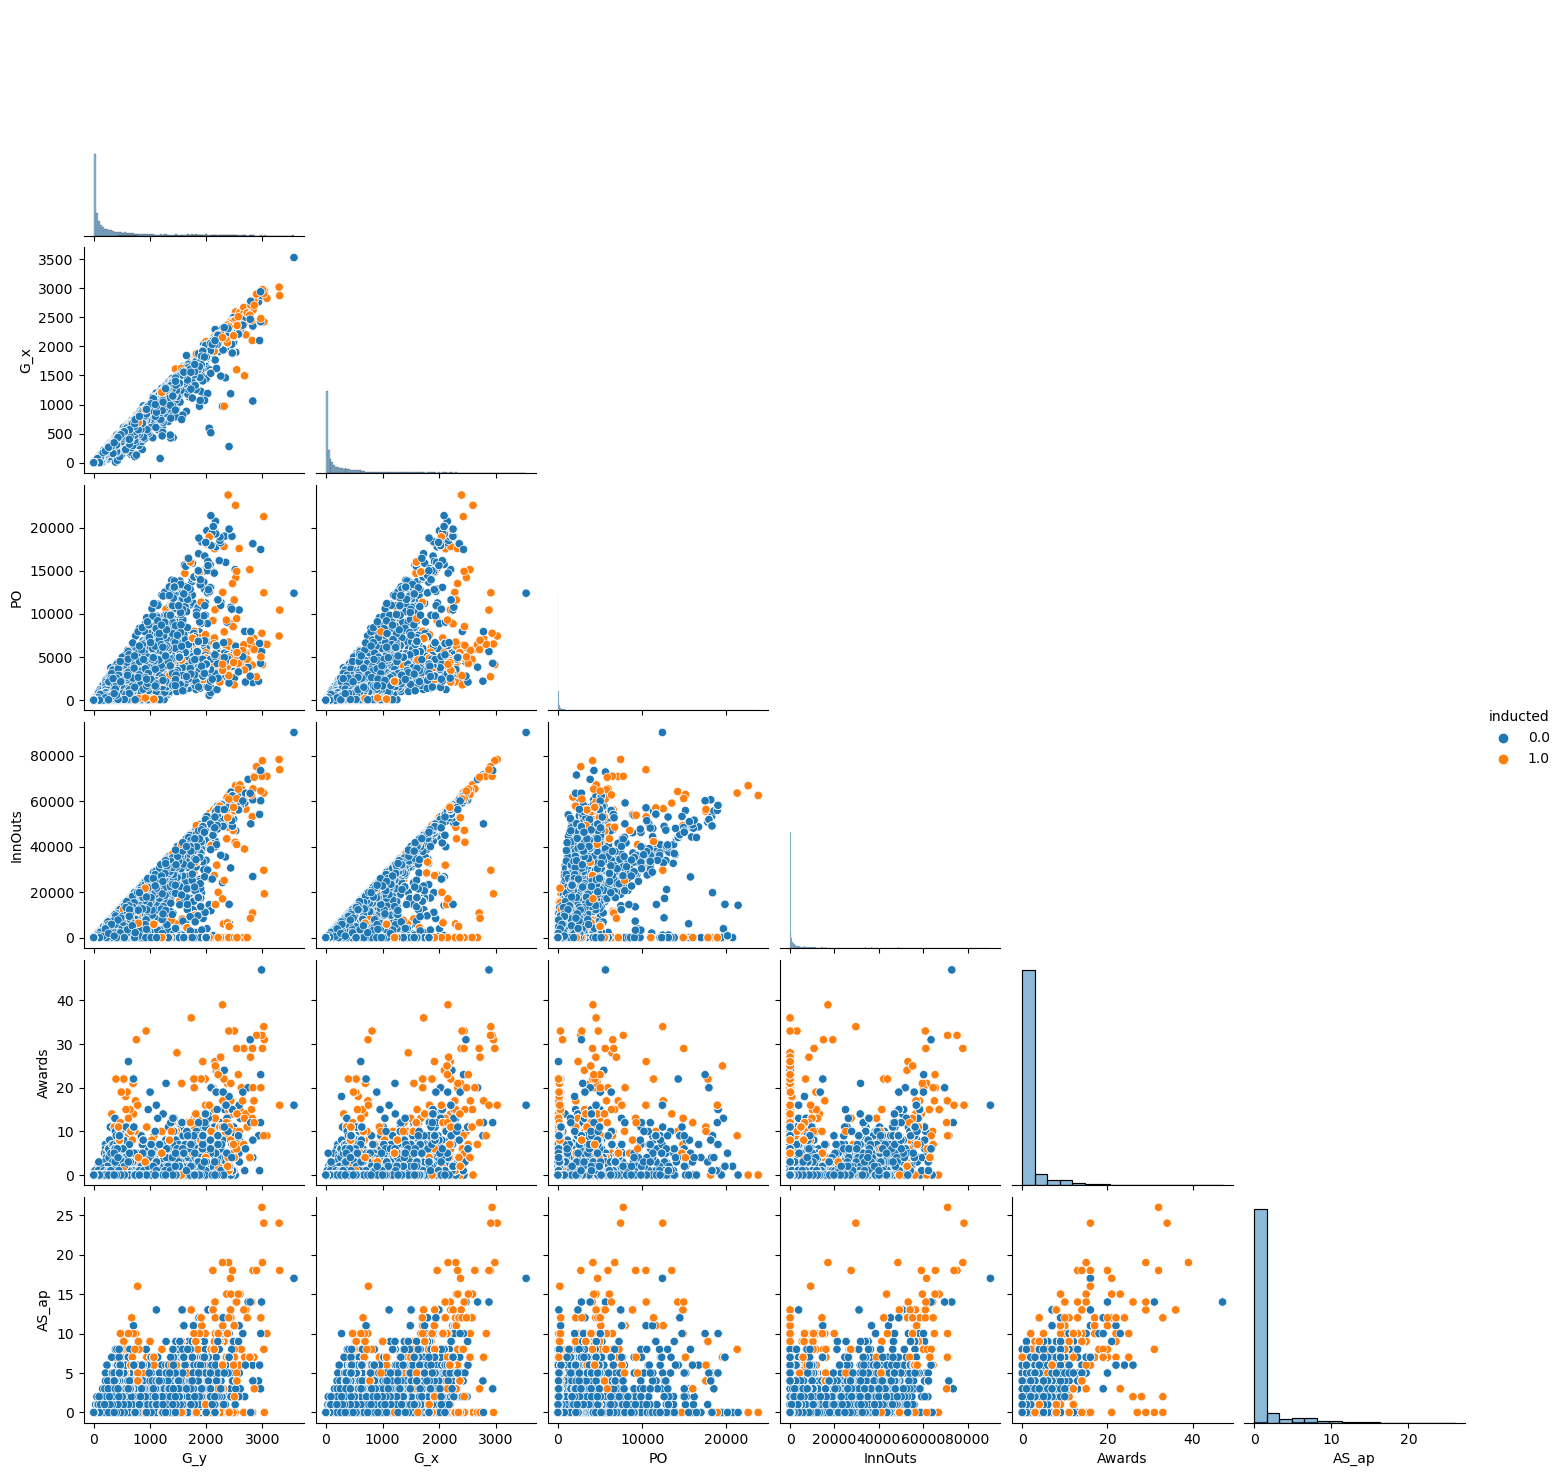

In [135]:
#Pair plot Not of all variables but what I thought would be the most important 
#All some forms of positive corrilations
sns.pairplot(data = merged_df,hue='inducted', diag_kind ="hist",corner = True,x_vars=['G_y','G_x','PO','InnOuts','Awards','AS_ap'],y_vars=['G_y','G_x','PO','InnOuts','Awards','AS_ap'])

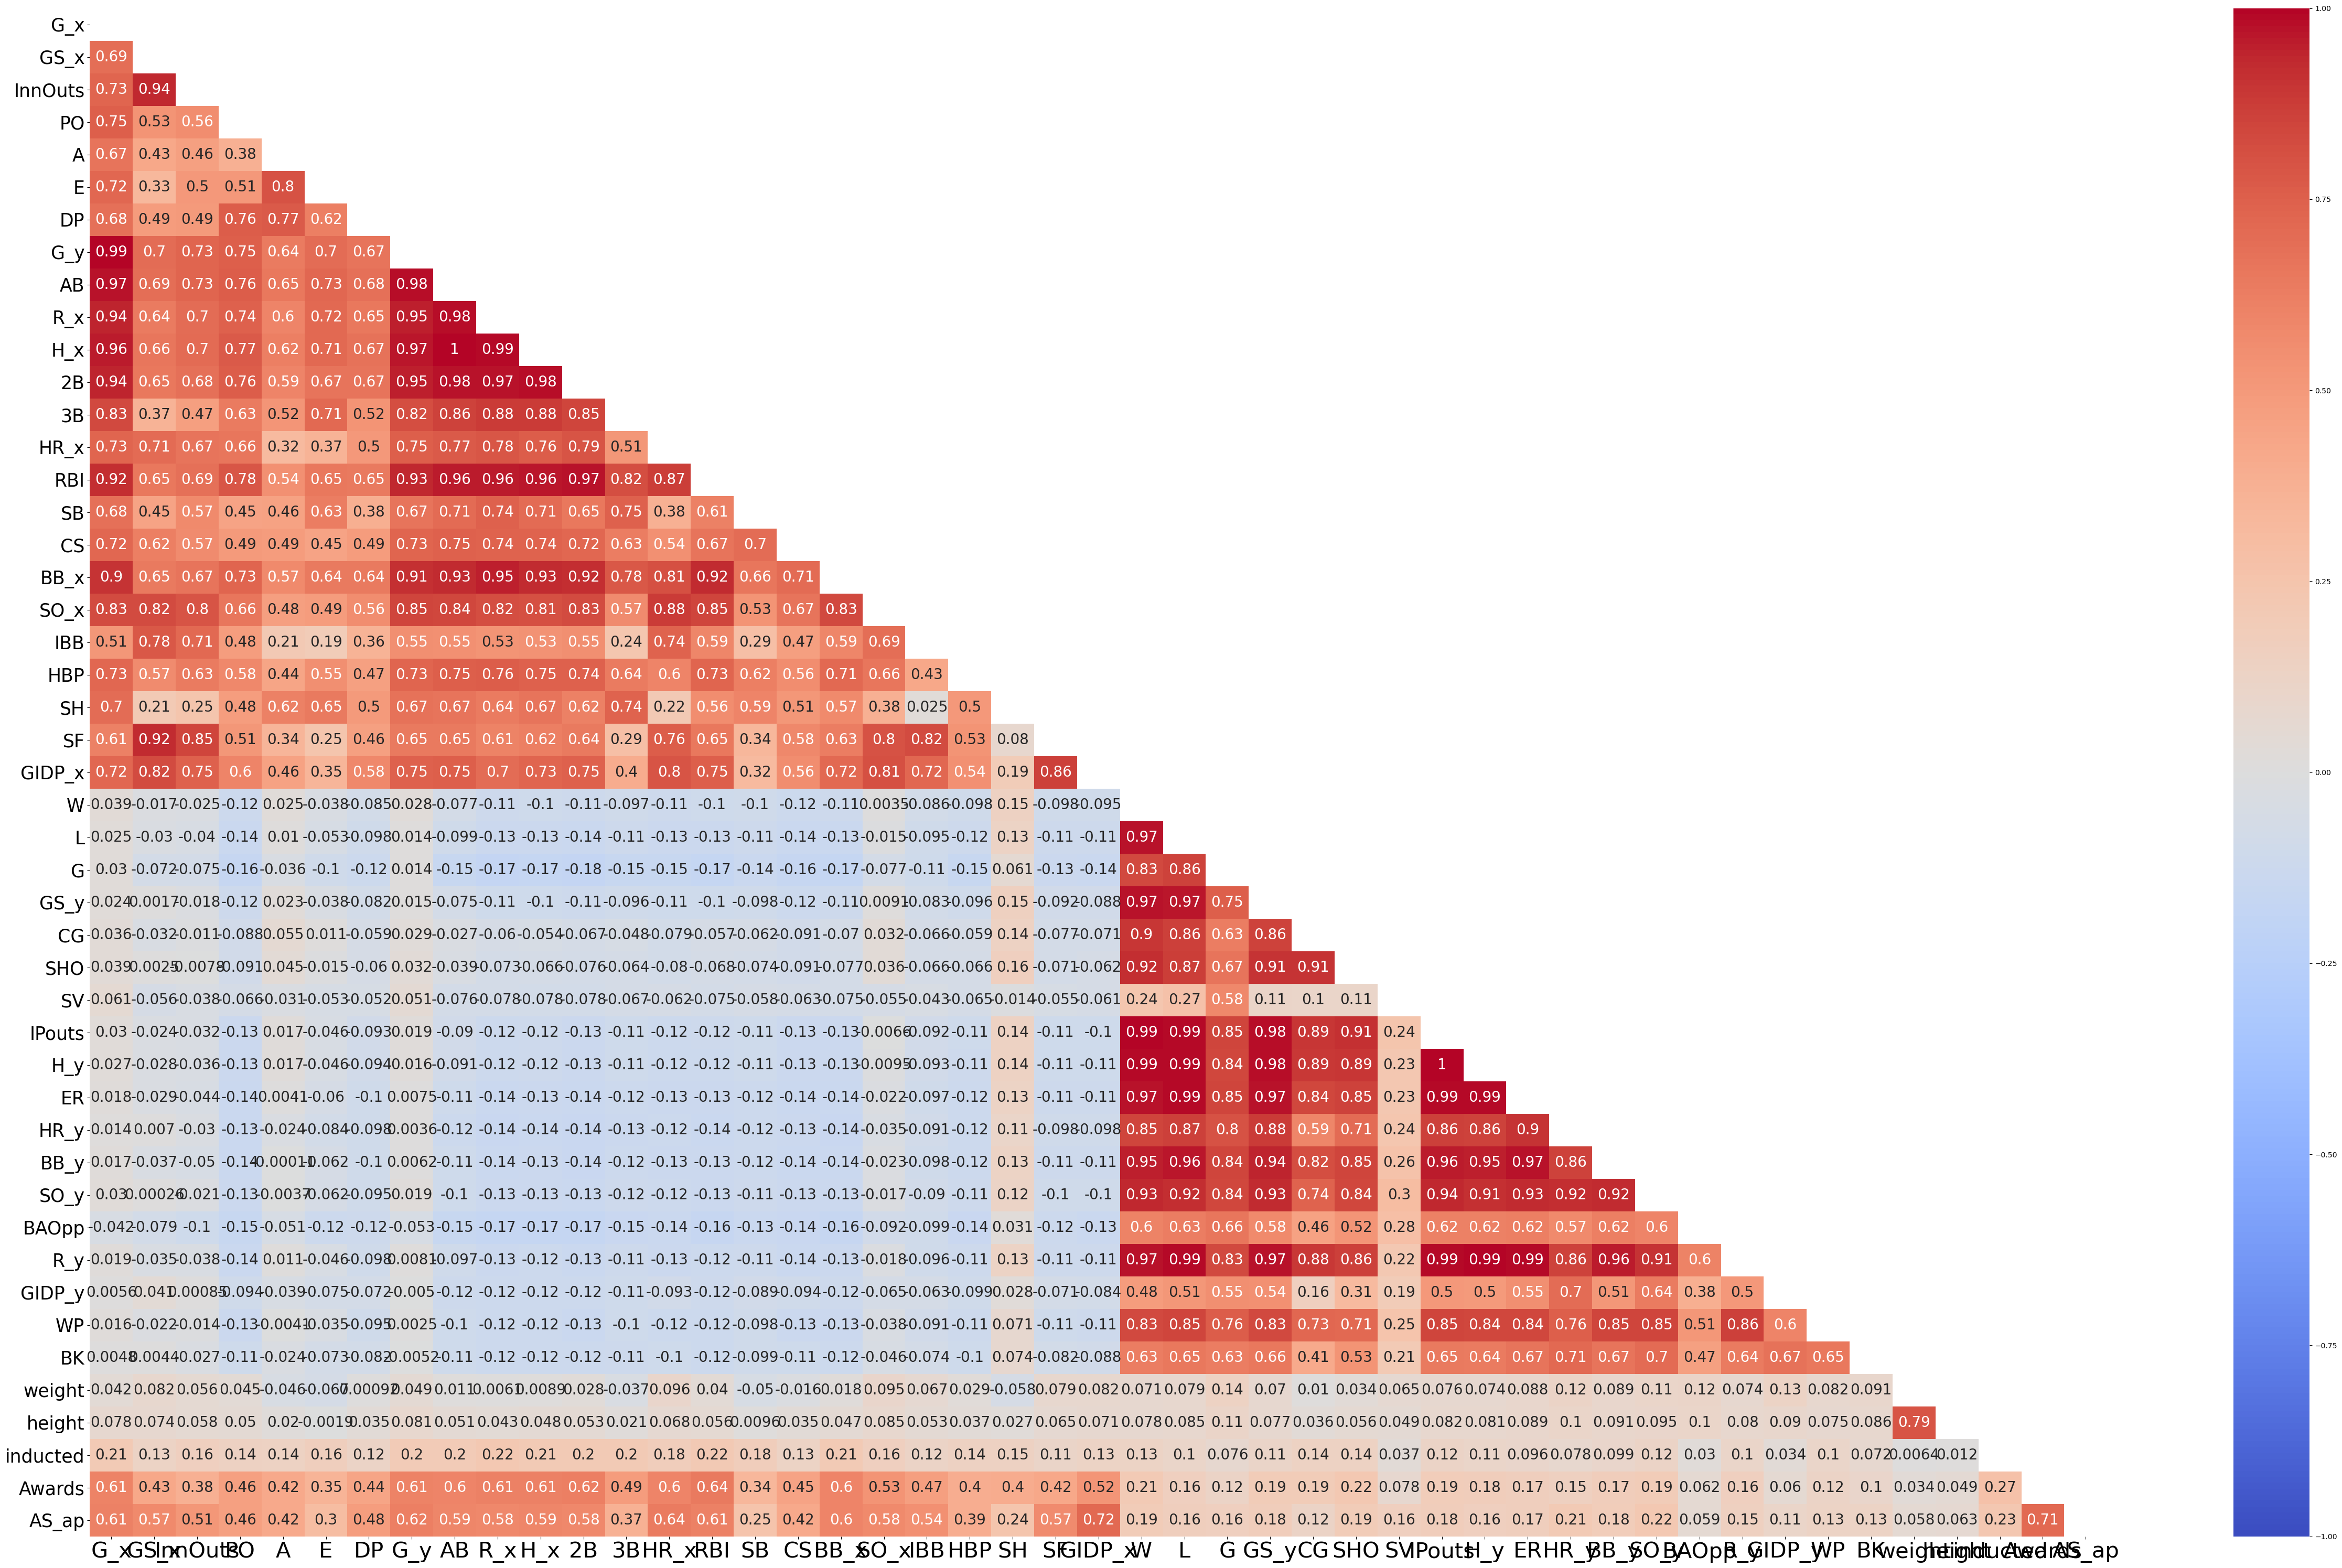

In [136]:
#Corrilations between all Variables
#Slightly Negative corrilations introduced with Pitching stats
#HOF is farily uncorrilated but slightly positive with all varaibles
#Awards and All star Apperances have a few high corrilations
corr = merged_df.corr()
fig, ax = plt.subplots(figsize=(50,30))
mask = np.zeros_like(corr, dtype=bool)  
mask[np.triu_indices_from(mask)] = True  
ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True, vmin=-1, vmax=1,annot_kws={'fontsize':20}, cmap='coolwarm')
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=30)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=25)
plt.tight_layout()
plt.show()

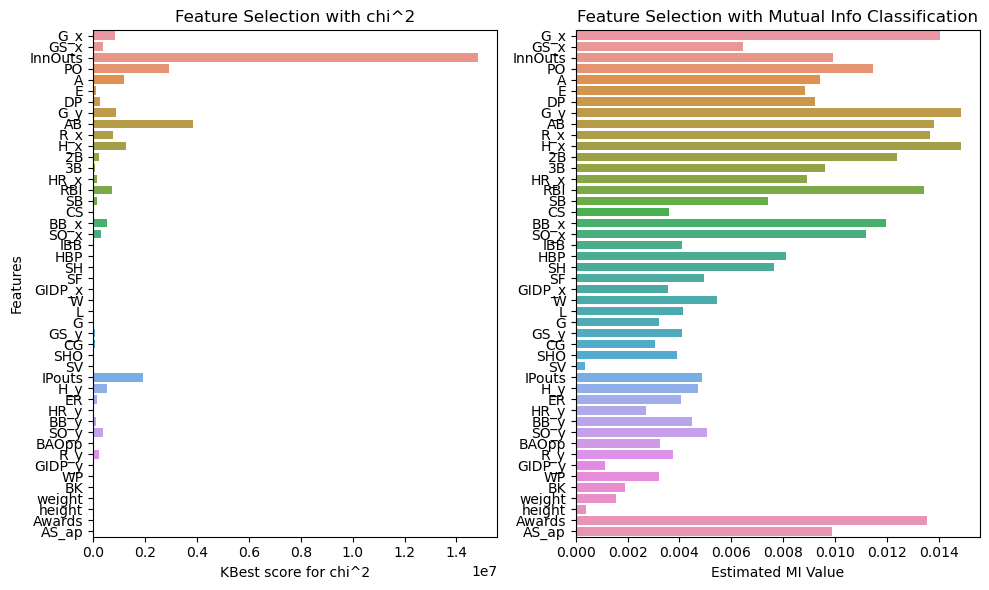

In [137]:
#Feature Selection for HOF statistic
#Notably Inn Outs, Awards, Hits, Games Played
fig_df = merged_df.drop(['nameFirst','nameLast','POS'],axis=1)
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(10, 6))

feature_selectors = {
    0: [chi2, 'KBest score for chi^2', 'Feature Selection with chi^2'], 
    1: [mutual_info_classif, 'Estimated MI Value', 'Feature Selection with Mutual Info Classification']
}

for i in range(2):
    # Learn relationship from data
    f_sel = SelectKBest(score_func=feature_selectors[i][0], k='all').fit(fig_df.drop('inducted',axis=1),fig_df['inducted'])
    # Transform input data
    x_fs = f_sel.transform(fig_df.drop('inducted',axis=1))
    # Plot score for each feature
    sns.barplot(x=f_sel.scores_, y=list(fig_df.drop('inducted',axis=1).columns), orient='h', ax=axs[i])
    axs[i].set_xlabel(feature_selectors[i][1])
    axs[i].set_title(feature_selectors[i][2])

axs[0].set_ylabel('Features')
plt.tight_layout()
plt.show()

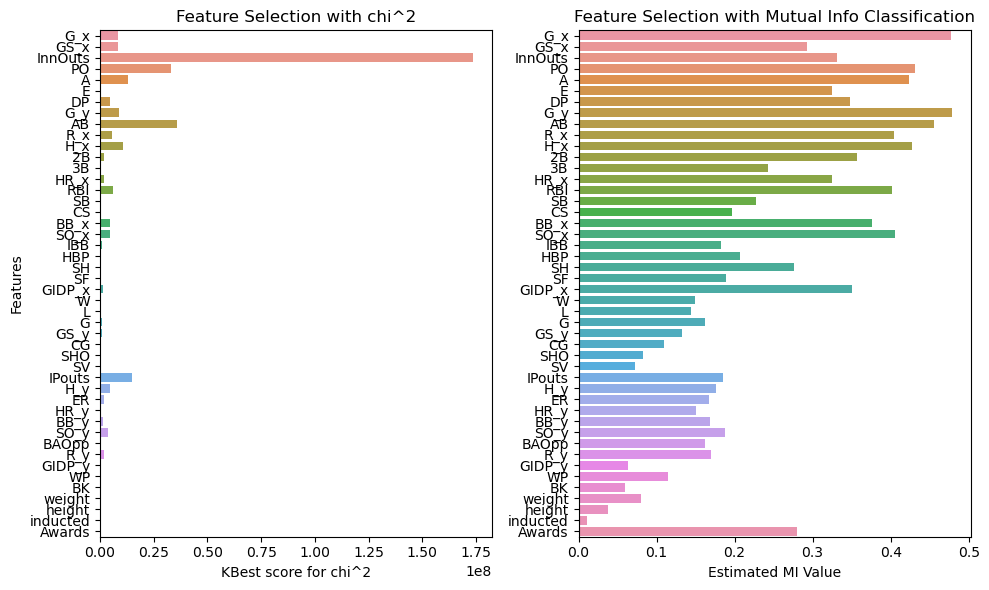

In [138]:
#Feature Selection for All Star Apperances statistic
#Notibly Games Played, At Bats, Put Outs, Inn Outs
fig_df = merged_df.drop(['nameFirst','nameLast','POS'],axis=1)
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(10, 6))

feature_selectors = {
    0: [chi2, 'KBest score for chi^2', 'Feature Selection with chi^2'], 
    1: [mutual_info_classif, 'Estimated MI Value', 'Feature Selection with Mutual Info Classification']
}

for i in range(2):
    # Learn relationship from data
    f_sel = SelectKBest(score_func=feature_selectors[i][0], k='all').fit(fig_df.drop('AS_ap',axis=1),fig_df['AS_ap'])
    # Transform input data
    x_fs = f_sel.transform(fig_df.drop('AS_ap',axis=1))
    # Plot score for each feature
    sns.barplot(x=f_sel.scores_, y=list(fig_df.drop('AS_ap',axis=1).columns), orient='h', ax=axs[i])
    axs[i].set_xlabel(feature_selectors[i][1])
    axs[i].set_title(feature_selectors[i][2])

axs[0].set_ylabel('Features')
plt.tight_layout()
plt.show()

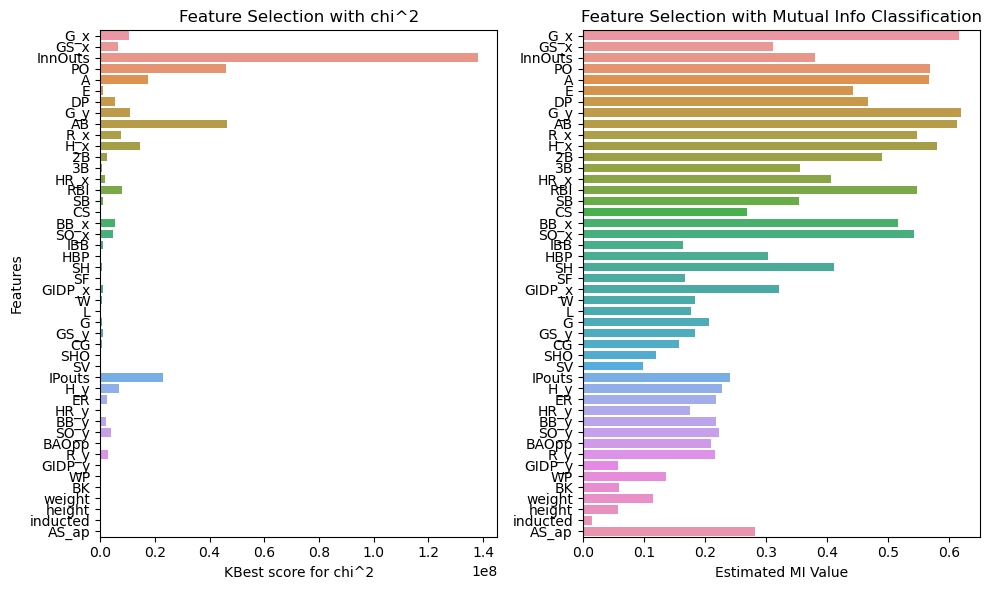

In [139]:
#Feature Selection for Awards statistic
#Notibly Inn Outs, Games, At Bats, Hits
fig_df = merged_df.drop(['nameFirst','nameLast','POS'],axis=1)
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(10, 6))

feature_selectors = {
    0: [chi2, 'KBest score for chi^2', 'Feature Selection with chi^2'], 
    1: [mutual_info_classif, 'Estimated MI Value', 'Feature Selection with Mutual Info Classification']
}

for i in range(2):
    # Learn relationship from data
    f_sel = SelectKBest(score_func=feature_selectors[i][0], k='all').fit(fig_df.drop('Awards',axis=1),fig_df['Awards'])
    # Transform input data
    x_fs = f_sel.transform(fig_df.drop('Awards',axis=1))
    # Plot score for each feature
    sns.barplot(x=f_sel.scores_, y=list(fig_df.drop('Awards',axis=1).columns), orient='h', ax=axs[i])
    axs[i].set_xlabel(feature_selectors[i][1])
    axs[i].set_title(feature_selectors[i][2])

axs[0].set_ylabel('Features')
plt.tight_layout()
plt.show()

In [140]:
#Train Test Split, After and Standardized Sclaer Transformation
y = merged_df['inducted']
X = merged_df.drop(['POS','nameLast','nameFirst','inducted'], axis=1)
standardizer = StandardScaler()
X = standardizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.25, random_state=0)

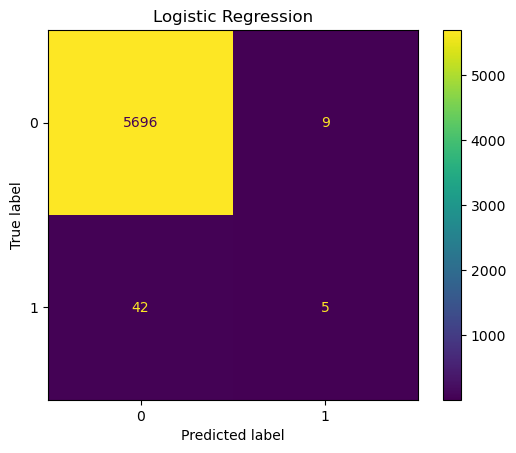

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      5738
         1.0       0.11      0.36      0.16        14

    accuracy                           0.99      5752
   macro avg       0.55      0.67      0.58      5752
weighted avg       1.00      0.99      0.99      5752



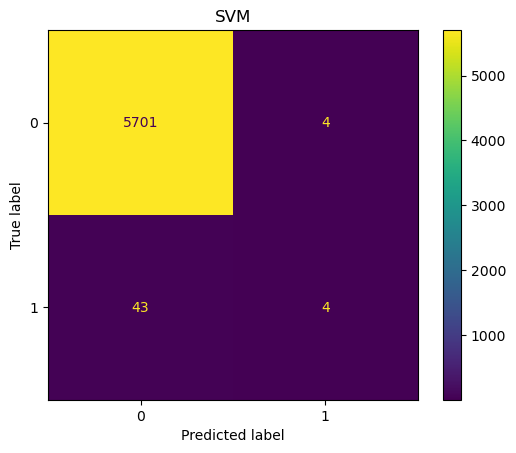

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      5744
         1.0       0.09      0.50      0.15         8

    accuracy                           0.99      5752
   macro avg       0.54      0.75      0.57      5752
weighted avg       1.00      0.99      0.99      5752



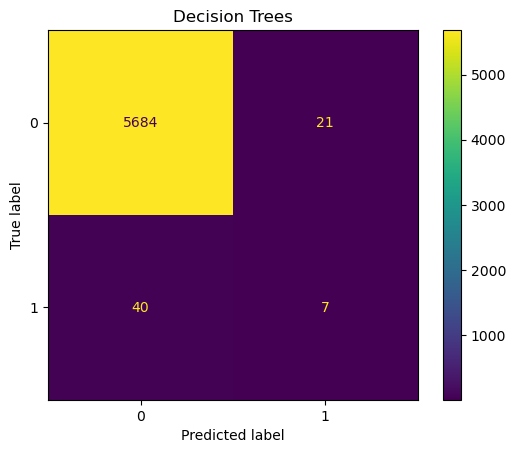

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      5724
         1.0       0.15      0.25      0.19        28

    accuracy                           0.99      5752
   macro avg       0.57      0.62      0.59      5752
weighted avg       0.99      0.99      0.99      5752



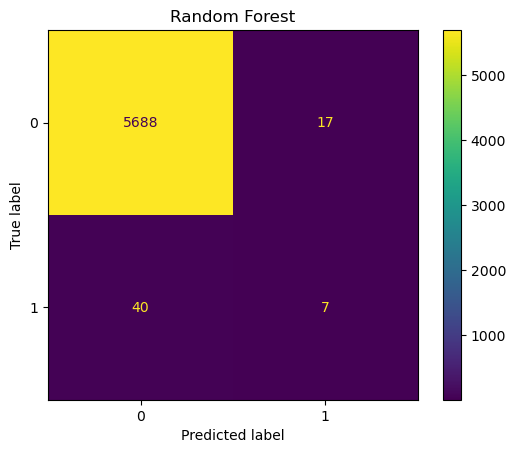

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      5728
         1.0       0.15      0.29      0.20        24

    accuracy                           0.99      5752
   macro avg       0.57      0.64      0.60      5752
weighted avg       0.99      0.99      0.99      5752



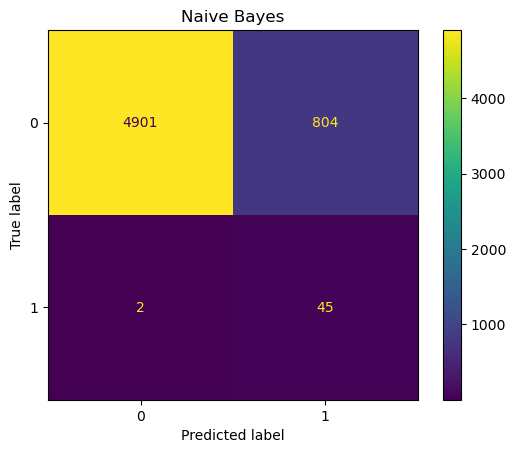

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92      4903
         1.0       0.96      0.05      0.10       849

    accuracy                           0.86      5752
   macro avg       0.91      0.53      0.51      5752
weighted avg       0.87      0.86      0.80      5752



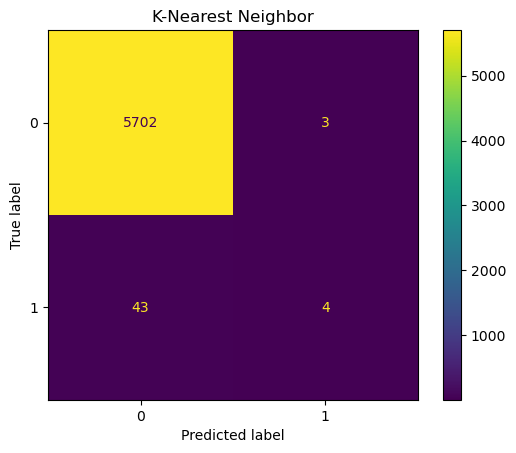

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      5745
         1.0       0.09      0.57      0.15         7

    accuracy                           0.99      5752
   macro avg       0.54      0.78      0.57      5752
weighted avg       1.00      0.99      0.99      5752

[15:38:03] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


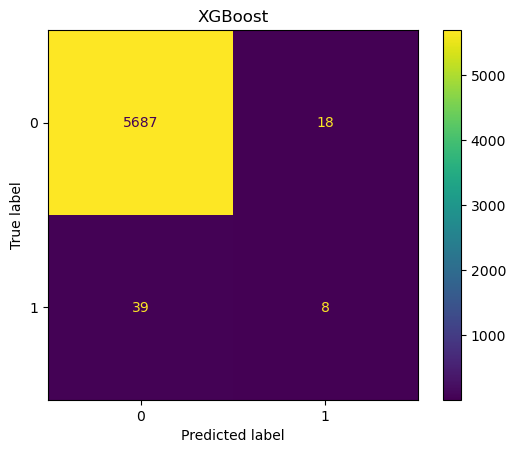

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      5726
         1.0       0.17      0.31      0.22        26

    accuracy                           0.99      5752
   macro avg       0.58      0.65      0.61      5752
weighted avg       0.99      0.99      0.99      5752



In [141]:
#7 models ran using a loop
#Calculated accuracy, percision, recall, f1 for all
#Displayed Confusion matrix and Clasification report
models = {}
# Logistic Regression
models['Logistic Regression'] = LogisticRegression()
# Support Vector Machines
models['SVM'] = LinearSVC()
# Decision Trees
models['Decision Trees'] = DecisionTreeClassifier()
# Random Forest
models['Random Forest'] = RandomForestClassifier()
# Naive Bayes
models['Naive Bayes'] = GaussianNB()
# K-Nearest Neighbors
models['K-Nearest Neighbor'] = KNeighborsClassifier()
# XG Boost
models['XGBoost'] = xgb.XGBClassifier()
accuracy, precision, recall, f1 = {}, {}, {}, {}

for key in models.keys():
    models[key].fit(X_train, y_train)
    predictions = models[key].predict(X_test)
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)
    f1[key] = f1_score(predictions,y_test)
    cm = confusion_matrix(y_test,predictions)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
    cm_display.plot()
    plt.title(key)
    plt.show()
    print(classification_report(predictions, y_test))

In [142]:
#Accuray was very High
#However Percision recall and f1 are very low
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall', 'F1'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['F1'] = f1.values()
df_model

,Accuracy,Precision,Recall,F1
Logistic Regression,0.991134,0.106383,0.357143,0.163934
SVM,0.991829,0.085106,0.500000,0.145455
Decision Trees,0.989395,0.148936,0.250000,0.186667
Random Forest,0.990090,0.148936,0.291667,0.197183
Naive Bayes,0.859875,0.957447,0.053004,0.100446
K-Nearest Neighbor,0.992003,0.085106,0.571429,0.148148
XGBoost,0.990090,0.170213,0.307692,0.219178


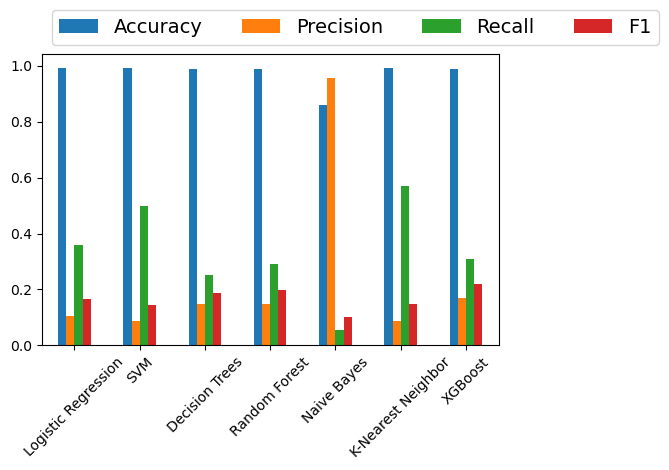

In [143]:
#Showing the differences between the techniques
#Very low scores besides accuracy
ax  = df_model.plot.bar(rot=45)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 14})
plt.tight_layout()

In [144]:
#Data is extremaly imbalanced
merged_df['inducted'].value_counts()

0.0    22775
1.0      230
Name: inducted, dtype: int64

How am I going to deal with this massive imbalance of the data.  
    1) Up sampling  
    2) Threshold Moving  

In [145]:
#Up sampling technique for imbalanced data
df_majority = merged_df[(merged_df['inducted']==0)] 
df_minority = merged_df[(merged_df['inducted']==1)] 
df_minority_upsampled = resample(df_minority, replace=True,n_samples= 22775,random_state=42) 
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

1.0    22775
0.0    22775
Name: inducted, dtype: int64


<AxesSubplot:xlabel='inducted', ylabel='count'>

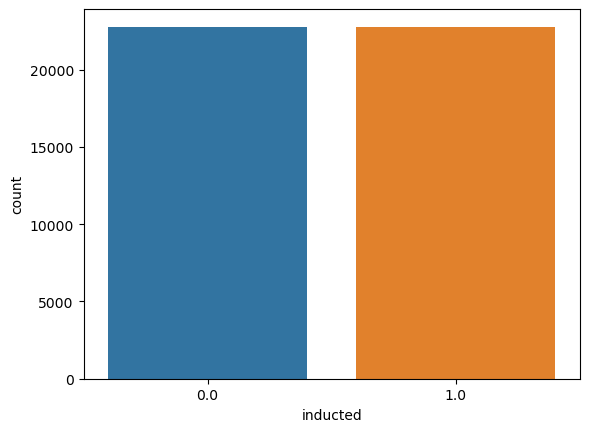

In [146]:
#Data is now evenly distributed
print(df_upsampled['inducted'].value_counts())
sns.countplot(df_upsampled['inducted'])

In [147]:
#Trying again Train Test Split with a Standared Scaler Transformation
y = df_upsampled['inducted']
X = df_upsampled.drop(['POS','nameLast','nameFirst','inducted'], axis=1)
standardizer = StandardScaler()
X = standardizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.25, random_state=0)

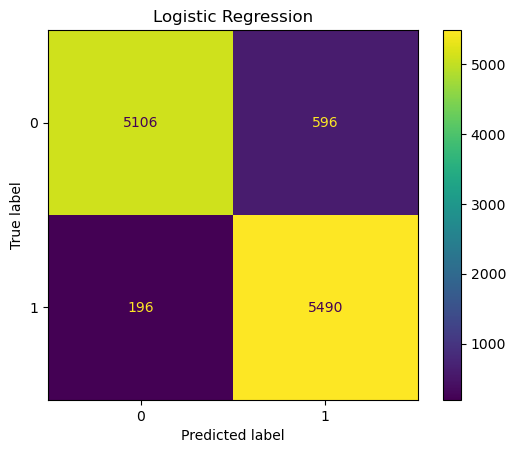

              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93      5302
         1.0       0.97      0.90      0.93      6086

    accuracy                           0.93     11388
   macro avg       0.93      0.93      0.93     11388
weighted avg       0.93      0.93      0.93     11388



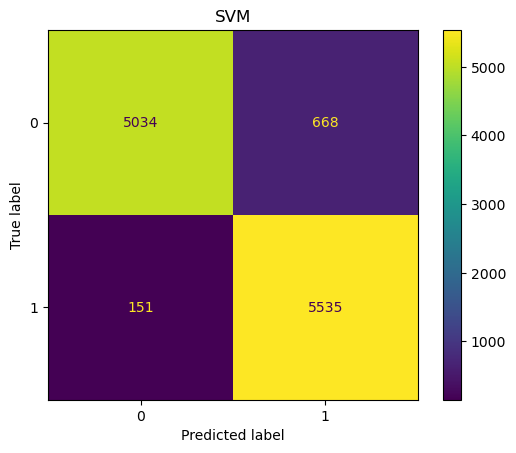

              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92      5185
         1.0       0.97      0.89      0.93      6203

    accuracy                           0.93     11388
   macro avg       0.93      0.93      0.93     11388
weighted avg       0.93      0.93      0.93     11388



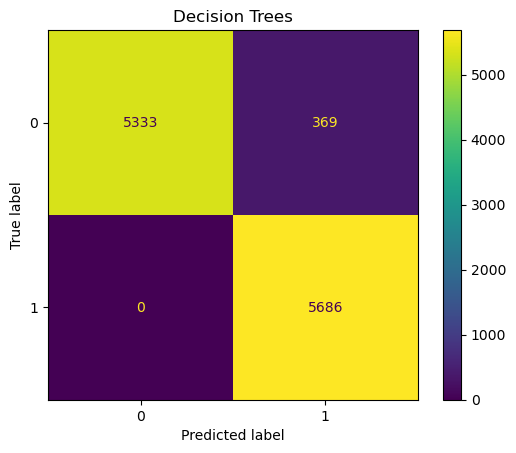

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      5333
         1.0       1.00      0.94      0.97      6055

    accuracy                           0.97     11388
   macro avg       0.97      0.97      0.97     11388
weighted avg       0.97      0.97      0.97     11388



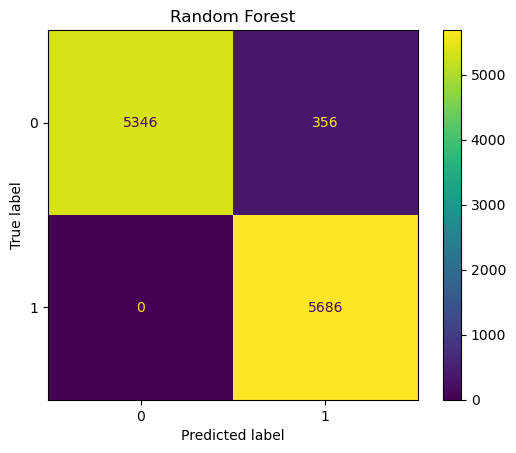

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      5346
         1.0       1.00      0.94      0.97      6042

    accuracy                           0.97     11388
   macro avg       0.97      0.97      0.97     11388
weighted avg       0.97      0.97      0.97     11388



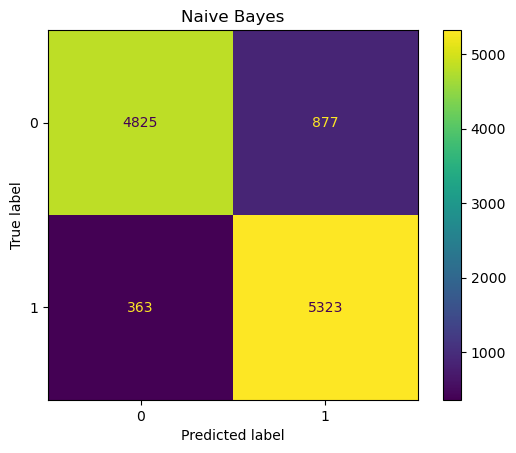

              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89      5188
         1.0       0.94      0.86      0.90      6200

    accuracy                           0.89     11388
   macro avg       0.89      0.89      0.89     11388
weighted avg       0.90      0.89      0.89     11388



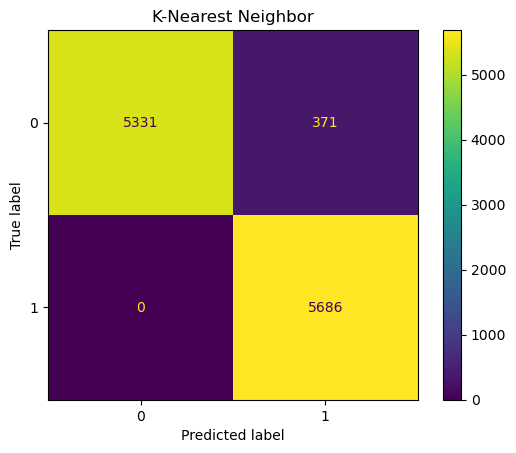

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97      5331
         1.0       1.00      0.94      0.97      6057

    accuracy                           0.97     11388
   macro avg       0.97      0.97      0.97     11388
weighted avg       0.97      0.97      0.97     11388

[15:38:26] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


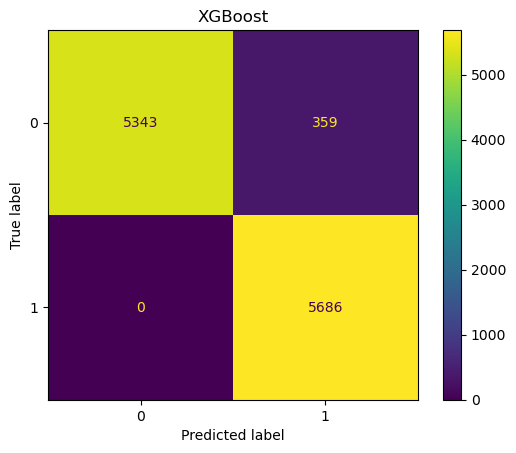

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      5343
         1.0       1.00      0.94      0.97      6045

    accuracy                           0.97     11388
   macro avg       0.97      0.97      0.97     11388
weighted avg       0.97      0.97      0.97     11388



In [148]:
#Ran all 7 models again in a loop
#Confusion matrix and Classification report are displayed
models = {}
# Logistic Regression
models['Logistic Regression'] = LogisticRegression()
# Support Vector Machines
models['SVM'] = LinearSVC()
# Decision Trees
models['Decision Trees'] = DecisionTreeClassifier()
# Random Forest
models['Random Forest'] = RandomForestClassifier()
# Naive Bayes
models['Naive Bayes'] = GaussianNB()
# K-Nearest Neighbors
models['K-Nearest Neighbor'] = KNeighborsClassifier()
# XG Boost
models['XGBoost'] = xgb.XGBClassifier()
accuracy, precision, recall, f1 = {}, {}, {}, {}

for key in models.keys():
    models[key].fit(X_train, y_train)
    predictions = models[key].predict(X_test)
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)
    f1[key] = f1_score(predictions,y_test)
    cm = confusion_matrix(y_test,predictions)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
    cm_display.plot()
    plt.title(key)
    plt.show()
    print(classification_report(predictions, y_test))

In [149]:
#Much better results
#Accuracy is a bit lower but percision recall and f1 scores are significanly higher
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall', 'F1'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['F1'] = f1.values()
df_model

,Accuracy,Precision,Recall,F1
Logistic Regression,0.930453,0.965529,0.902070,0.932722
SVM,0.928082,0.973444,0.892310,0.931113
Decision Trees,0.967597,1.000000,0.939059,0.968572
Random Forest,0.968739,1.000000,0.941079,0.969645
Naive Bayes,0.891113,0.936159,0.858548,0.895676
K-Nearest Neighbor,0.967422,1.000000,0.938749,0.968407
XGBoost,0.968476,1.000000,0.940612,0.969397


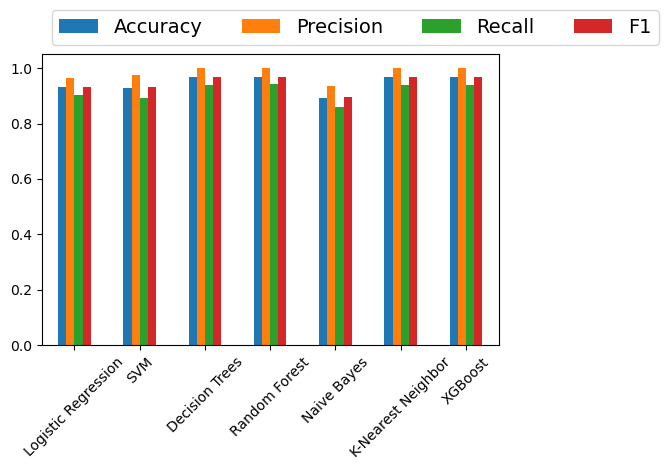

In [150]:
#Visual proof of our improvment with upsampling
ax  = df_model.plot.bar(rot=45)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 14})
plt.tight_layout()

## Answer to Question 1
### What Statistics make a Hall Of Fame Player?
Based on the Feature Importance of my analysis the prominate states that make a Hall Of Fame Player are Games played, having a low amount of Strike Outs as a batter, having been honored for your play with awards, the total number of at bats, and the amount of douple plays the player has caused as a batter.
Most of these statistics come with longevity through out the season of play and having consistant play over a long number of seasons. These are the statistics that have the largest affect on players being in the Hall Of Fame, like I said above it has most to do with longevity and consistancy. 

Text(0.5, 1.0, 'Random Forest Feature Importance')

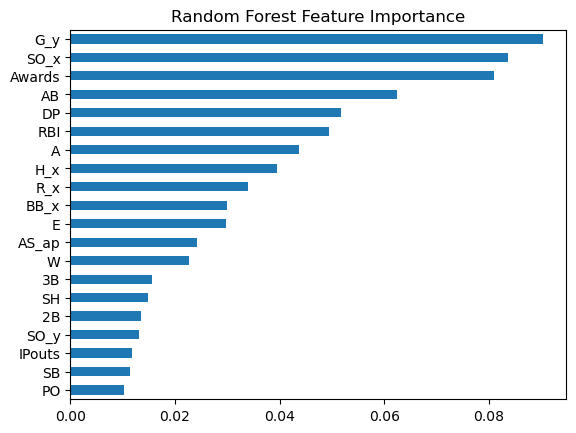

In [151]:
#Feature importance of the Random Forest technique
#Games Played, Awards, Strike Outs, At bats, Errors
#Highest contributing featrues for predicting HOF Players
sort = pd.Series(models['Random Forest'].feature_importances_, index=merged_df.drop(['POS','nameLast','nameFirst','inducted'], axis=1).columns)
sort.sort_values()[25:-1].plot.barh()
plt.title('Random Forest Feature Importance')

Text(0.5, 1.0, 'XGBoost Feature Importance')

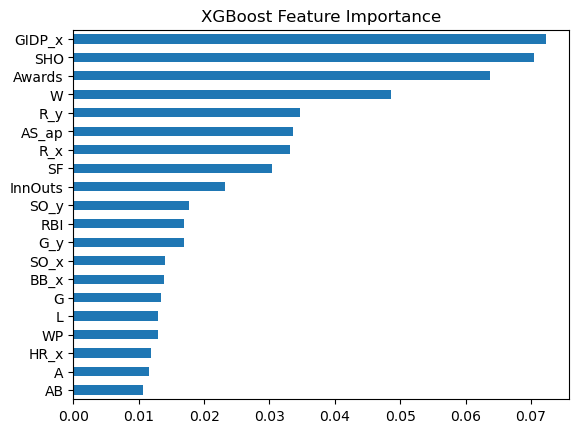

In [152]:
#Feature importance of the XGBoost technique
#Ground into Double Plays, Shut Outs, Awards, Wins, Runs allowed
#Highest contributing featrues for predicting HOF Players
sort = pd.Series(models['XGBoost'].feature_importances_, index=merged_df.drop(['POS','nameLast','nameFirst','inducted'], axis=1).columns)
sort.sort_values()[25:-1].plot.barh()
plt.title('XGBoost Feature Importance')

In [153]:
#Going to attempt threshold moving to improve the Random Forest Model which was the highest performing
#Optimal Threshold identified as .7
step_factor = 0.05 
threshold_value = 0.2 
roc_score=0
predicted_proba = models['Random Forest'].predict_proba(X_test)
while threshold_value <=0.8: 
    temp_thresh = threshold_value
    predicted = (predicted_proba [:,1] >= temp_thresh).astype('int') 
    print('Threshold',temp_thresh,'--',roc_auc_score(y_test, predicted))
    if roc_score<roc_auc_score(y_test, predicted):
        roc_score = roc_auc_score(y_test, predicted)
        thrsh_score = threshold_value
    threshold_value = threshold_value + step_factor
print('---Optimum Threshold ---',thrsh_score,'--ROC--',roc_score)

Threshold 0.2 -- 0.9672044896527534
Threshold 0.25 -- 0.9677306208347949
Threshold 0.3 -- 0.9680813749561558
Threshold 0.35 -- 0.9682567520168361
Threshold 0.39999999999999997 -- 0.9686075061381971
Threshold 0.44999999999999996 -- 0.9686951946685374
Threshold 0.49999999999999994 -- 0.9687828831988775
Threshold 0.5499999999999999 -- 0.9688705717292178
Threshold 0.6 -- 0.9689582602595581
Threshold 0.65 -- 0.9689582602595581
Threshold 0.7000000000000001 -- 0.9692213258505787
Threshold 0.7500000000000001 -- 0.9692213258505787
---Optimum Threshold --- 0.7000000000000001 --ROC-- 0.9692213258505787


In [154]:
#With the Threshold I was able so increase Accuracy, Recall, and F1 Score
df_model

,Accuracy,Precision,Recall,F1
Logistic Regression,0.930453,0.965529,0.902070,0.932722
SVM,0.928082,0.973444,0.892310,0.931113
Decision Trees,0.967597,1.000000,0.939059,0.968572
Random Forest,0.968739,1.000000,0.941079,0.969645
Naive Bayes,0.891113,0.936159,0.858548,0.895676
K-Nearest Neighbor,0.967422,1.000000,0.938749,0.968407
XGBoost,0.968476,1.000000,0.940612,0.969397


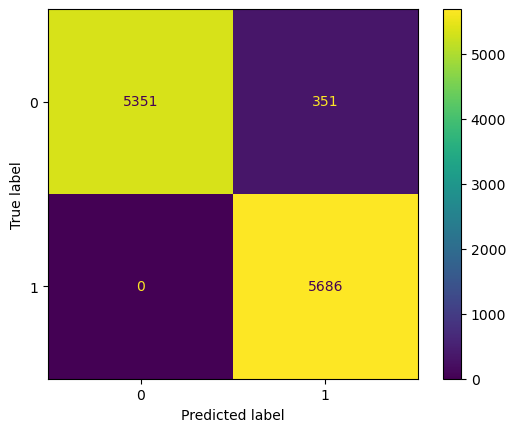

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      5343
         1.0       1.00      0.94      0.97      6045

    accuracy                           0.97     11388
   macro avg       0.97      0.97      0.97     11388
weighted avg       0.97      0.97      0.97     11388



In [155]:
#Confusion Matrix and Classification report for Optimal Tuned Random Forest model
predicted_proba = models['Random Forest'].predict_proba(X_test)
predicted = (predicted_proba[:,1] >= .7).astype('int')
accuracy['RF.7'] = accuracy_score(predicted, y_test)
precision['RF.7'] = precision_score(predicted, y_test)
recall['RF.7'] = recall_score(predicted, y_test)
f1['RF.7'] = f1_score(predicted,y_test)
cm = confusion_matrix(y_test,predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()
print(classification_report(predictions, y_test))

## Answer to Question 2
### Who can use this and how can it be used?
Having tweaked the model with the upsampling and threashold techniques the final algorithm performs admiarbly well at prediction. So I test the model on some well know players and some up and coming players. For the well know players the algorithm was able to accuratly predict their Hall Of Fame status. However one player who was inducted last year was predicted incorretly. For the up and coming players only one was predicted to be in the Hall Of Fame even though he is not yet elligable. I believe  this has to do with the players logevity in the league and the consistency he has displayed over the years.  
This can be used for scouts, coaches, managers and players to see how their stats stake up to Hall Of Fame players. I think that becasue of the longevity aspect this can be used with new up and coming players with their states projected based on their current play to see how they will add up over the years. Therefore the most important thing for looking at young players is how do we keep them healthy and in the best form so we can get the longest rain of them at their peak. 

In [156]:
#All models side by side
models['RF.7'] = 'Random Forest'
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall', 'F1'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['F1'] = f1.values()
df_model

,Accuracy,Precision,Recall,F1
Logistic Regression,0.930453,0.965529,0.902070,0.932722
SVM,0.928082,0.973444,0.892310,0.931113
Decision Trees,0.967597,1.000000,0.939059,0.968572
Random Forest,0.968739,1.000000,0.941079,0.969645
Naive Bayes,0.891113,0.936159,0.858548,0.895676
K-Nearest Neighbor,0.967422,1.000000,0.938749,0.968407
XGBoost,0.968476,1.000000,0.940612,0.969397
RF.7,0.969178,1.000000,0.941859,0.970059


In [171]:
#Testing model on some well know players and up and coming players
dj = merged_df[ (merged_df['nameFirst'] == 'Derek') & (merged_df['nameLast'] == 'Jeter') ].drop(['POS','nameLast','nameFirst','inducted'], axis=1)
do = merged_df[ (merged_df['nameFirst'] == 'David') & (merged_df['nameLast'] == 'Ortiz') ].drop(['POS','nameLast','nameFirst','inducted'], axis=1)
dw = merged_df[ (merged_df['nameFirst'] == 'David') & (merged_df['nameLast'] == 'Wright') ].drop(['POS','nameLast','nameFirst','inducted'], axis=1)
ha = merged_df[ (merged_df['nameFirst'] == 'Hank') & (merged_df['nameLast'] == 'Aaron') ].drop(['POS','nameLast','nameFirst','inducted'], axis=1)
cy = merged_df[ (merged_df['nameFirst'] == 'Cy') & (merged_df['nameLast'] == 'Young') ].drop(['POS','nameLast','nameFirst','inducted'], axis=1)
aj = merged_df[ (merged_df['nameFirst'] == 'Aaron') & (merged_df['nameLast'] == 'Judge') ].drop(['POS','nameLast','nameFirst','inducted'], axis=1)
mp = merged_df[ (merged_df['nameFirst'] == 'Mike') & (merged_df['nameLast'] == 'Piazza') ].drop(['POS','nameLast','nameFirst','inducted'], axis=1)

x = pd.concat([do,dj,dw,ha,cy,aj,mp])

In [172]:
#Using my .7 threshold all 0's were predicted
predicted_proba_test = models['Random Forest'].predict_proba(x)
predicted_proba_test
predicted = (predicted_proba_test[:,1] >= .7).astype('int')
print(predicted)

[0 0 0 0 0 0 0 0 0 0 0 0]


In [173]:
#Had better results without the threshold
predictions = models[key].predict(x)
print(predictions)

[0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
